In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skll.metrics import kappa
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from kappa_loss import KappaLossNN, KappaLossLGBM
from jax.nn import selu
%load_ext line_profiler

Playground notebook for kappa loss models

In [14]:
df = pd.read_csv("./data/preprocessed_data.csv", index_col=0)
TARGET = "NSP"
FEATURES = df.columns.drop(TARGET)
Xdf = df[FEATURES]
ydf = df[TARGET]
NUM_CLASSES = 3
# Without normalizing the data, the optimizer got stuck in local minima
X = StandardScaler().fit(Xdf.values).transform(Xdf.values)
y = ydf.values - 1 #type: ignore
# X = Xdf.values
# need to have the classes start at 0 instead of 1 for scoring to work properly

weights = np.array([
# Predicted   N    S    P     # True
            [0.0, 0.5, 0.6],  # N
            [1.0, 0.0, 0.3],  # S
            [2.0, 0.6, 0.0]   # P
])

klp = KappaLossNN( early_stopping_min_improvement=-0.1,
    num_classes=NUM_CLASSES, weight_matrix=weights, alpha=0, 
    hidden_layer_shapes=[30, 20,10, 5], hidden_layer_actvation=selu,
    )


Score: 0.9475922053195376


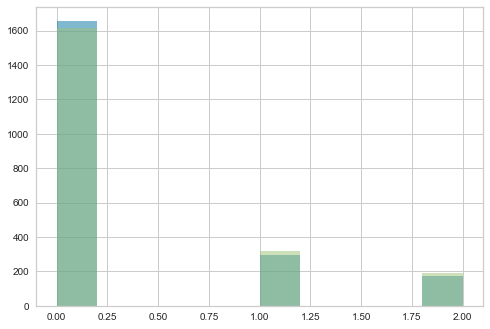

<AxesSubplot:title={'center':'Learning Curve'}>

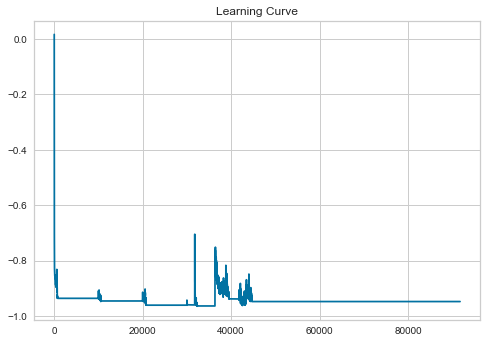

In [25]:
klp.fit(X, y, max_iter=10000, verbose=False, warm_start=True)
print("Score:", klp.prediction_kappa(X, y))
y_hat = klp.predict(X)
pd.Series(y).hist(alpha=.5) 
pd.Series(y_hat).hist(alpha=.5) 
plt.show()
pd.Series(klp.loss_values).astype(float).plot(title="Learning Curve")

In [6]:
def weightedKappa(x, y): return kappa(x, y, weights=weights)
kappaScorer = make_scorer(weightedKappa)

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=2)
sizes = np.linspace(0.3, 1.0, 10)

In [7]:
# Instantiate the classification model and visualizer
# visualizer = LearningCurve(
#     klp, cv=cv, scoring=kappaScorer, train_sizes=sizes, n_jobs=-1
# )
# x = visualizer.fit(X, y)        # Fit the data to the visualizer
# visualizer.show()           # Finalize and render the figuremport numpy as np

In [8]:
lgbm = KappaLossLGBM(weight_matrix=list(weights), num_classes=3)

In [12]:
import os
os.environ['JAX_LOG_COMPILES'] = "1"

In [13]:
from jax import grad 
%lprun -f grad lgbm.fit(X, y) 

Timer unit: 1e-06 s

Total time: 0.01614 s
File: /Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/jax/_src/api.py
Function: grad at line 858

Line #      Hits         Time  Per Hit   % Time  Line Contents
   858                                           def grad(fun: Callable, argnums: Union[int, Sequence[int]] = 0,
   859                                                    has_aux: bool = False, holomorphic: bool = False,
   860                                                    allow_int: bool = False,
   861                                                    reduce_axes: Sequence[AxisName] = ()) -> Callable:
   862                                             """Creates a function that evaluates the gradient of ``fun``.
   863                                           
   864                                             Args:
   865                                               fun: Function to be differentiated. Its arguments at positions specified by
   866             

In [20]:
lgbm.predict_proba(X)

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:999: UserWarning: Cannot compute class probabilities or labels due to the usage of customized objective function.
Returning raw scores instead.
  _log_warning("Cannot compute class probabilities or labels "


DeviceArray([1, 0, 0, ..., 1, 1, 1], dtype=int32)

/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:672: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 203, in <module>
    exitcode = process_obj._bootstrap()
  File "/Users/luke/.pyenv/versions/3.9.1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/luke/.pyenv/versions/3.9.1/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/Users/luke/projects/old/ctg/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_execut

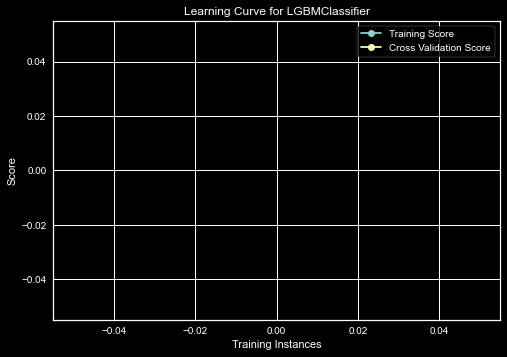

<AxesSubplot:title={'center':'Learning Curve for LGBMClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [14]:
# %debug
# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    lgbm, cv=cv, scoring=kappaScorer, train_sizes=sizes, n_jobs=1
)
x = visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figuremport numpy as np